In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_circles, make_moons


In [2]:
# 1 is real noise, 0 is real data
# code partly adapted from: https://github.com/VinAIResearch/LFM/blob/main/train_flow_latent.py

In [3]:
def sample_t(z0_shape):
    batch_size, rest_dimensions = z0_shape[0], z0_shape[1:]
    # Sample Uniform t and reshape it for broadcasting
    return torch.rand(size=(batch_size, *([1] * len(rest_dimensions))))


def sample_z1(z0_shape, mean=0, std=1):
    return torch.randn(z0_shape) * std + mean


def generate_trajectory(z0, z1, t, sigma):
    return (1 - t) * z0 + (sigma + (1 - sigma) * t) * z1


def match_closest_samples(z0, z1):
    batch_size = z0.shape[0]
    # Flatten the tensors to shape (batch_size, -1)
    A_flat = z0.reshape(batch_size, -1)
    B_flat = z1.reshape(batch_size, -1)

    # Compute the (batch_size, batch_size) distance matrix
    D = np.linalg.norm(A_flat[:, None] - B_flat[None, :], axis=2)

    # Use the linear sum assignment algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(D)
    # permute the rows of B to match the columns of A
    B_matched = B_flat[col_ind]
    B_matched = B_matched.reshape(z1.shape)
    return z0, B_matched


# z0 = torch.randn(size=(10, 128, 128))
# t = sample_t(z0.shape)
# z1 = sample_z1(z0.shape)

# trajectory = generate_trajectory(z0=z0, z1=z1, t=t)


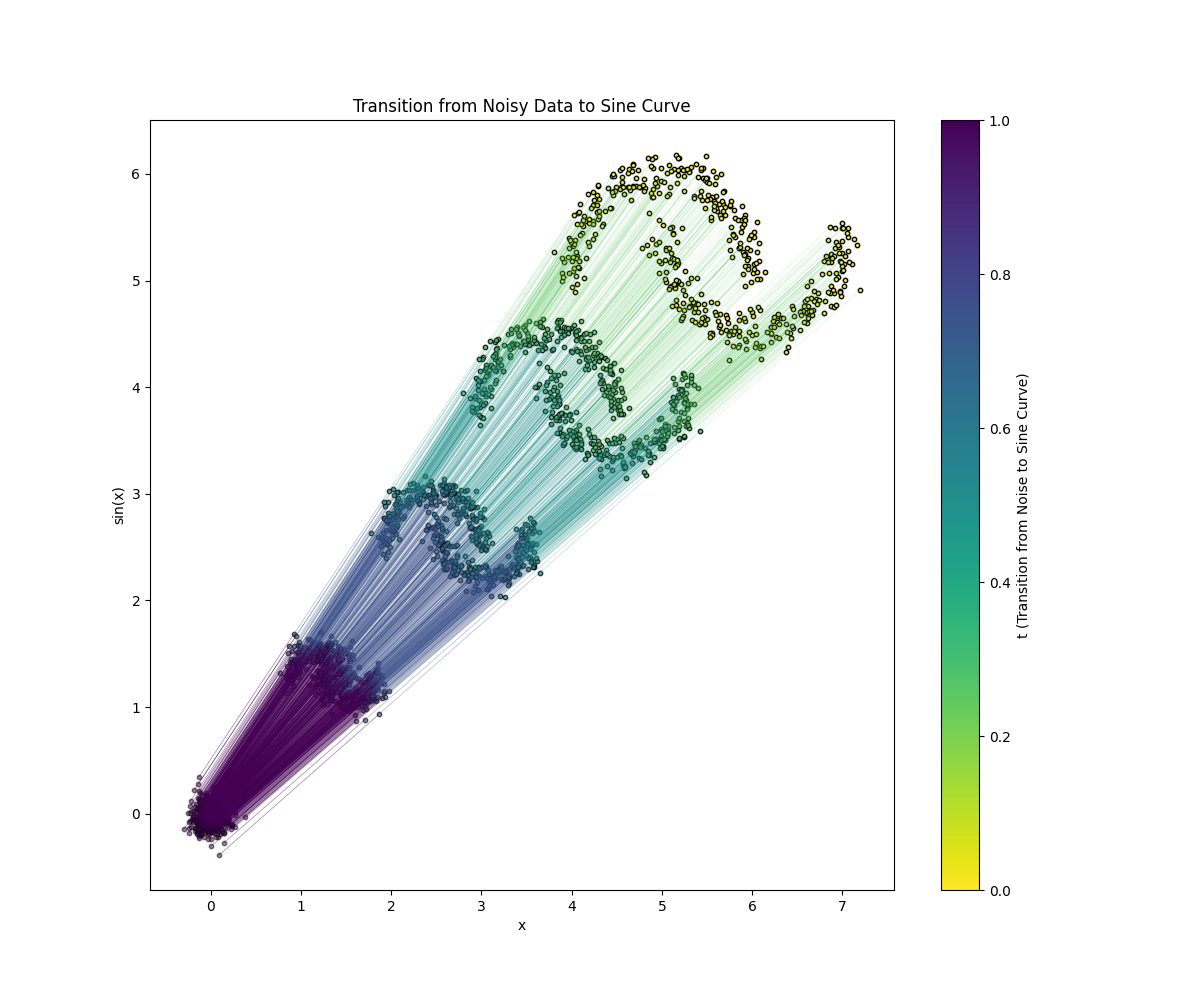

In [9]:
def visualize_trajectory_sine_curve(z0, z1, n_steps, sigma):
    z0, z1 = match_closest_samples(z0, z1)

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    # Color map for trajectory progression
    color_map = plt.cm.viridis_r
    norm = plt.Normalize(vmin=0, vmax=1)

    # Store the previous trajectory for connecting lines
    previous_trajectory = None

    # Iterate over n_steps and plot each trajectory step with color-coded transparency
    for _step, t_value in enumerate(torch.linspace(0, 1, n_steps)):
        # Repeat t for batch size of z0 (if z0 has more than one trajectory)
        t = t_value.repeat(z0.shape[0], 1)
        # Calculate the trajectory at this step
        trajectory = generate_trajectory(z0=z0, z1=z1, t=t, sigma=sigma)

        # Scatter plot for each trajectory step with color gradient
        alpha_scatter = 1 - (0.5 * t_value.item())

        ax.scatter(
            trajectory[:, 0].cpu().numpy(),
            trajectory[:, 1].cpu().numpy(),
            color=color_map(norm(t_value.item())),
            alpha=alpha_scatter,
            s=10,  # Size of scatter points
            # border
            edgecolors="k",
        )

        # Connect points from previous trajectory to current trajectory
        if previous_trajectory is not None:
            for i in range(trajectory.shape[0]):
                alpha_line = 0.1 + 0.4 * t_value.item()
                ax.plot(
                    [
                        previous_trajectory[i, 0].cpu().numpy(),
                        trajectory[i, 0].cpu().numpy(),
                    ],
                    [
                        previous_trajectory[i, 1].cpu().numpy(),
                        trajectory[i, 1].cpu().numpy(),
                    ],
                    color=color_map(norm(t_value.item())),
                    alpha=alpha_line,
                    linewidth=0.5,
                )

        # Update previous trajectory
        previous_trajectory = trajectory.clone()

    # Add colorbar to indicate progression of t
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="t (Transition from Noise to Sine Curve)")

    # Plot labels
    ax.set_title("Transition from Noisy Data to Sine Curve")
    ax.set_xlabel("x")
    ax.set_ylabel("sin(x)")
    plt.show()


# Define z0 as the sine wave and z1 as noisy data
n_samples = 500
n_steps = 5

data = make_moons(n_samples=n_samples, noise=0.1)

# ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- D A T A
z0 = torch.tensor(data[0], dtype=torch.float32) + 5

# inputs_ = torch.linspace(-torch.pi, torch.pi, n_samples)
# x = torch.sin(inputs_)
# z0 = torch.stack((inputs_, x), dim=1)  # Shape (n_samples, 2)

# ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- N O I S E
z1 = sample_z1(z0.shape,mean=0,std=0.1)

#z1 = make_circles(n_samples=n_samples, noise=0.1, factor=0.1)[0]
# Call the visualization function with z0, z1, and n_steps
visualize_trajectory_sine_curve(z0, z1, n_steps=n_steps, sigma=1e-5)


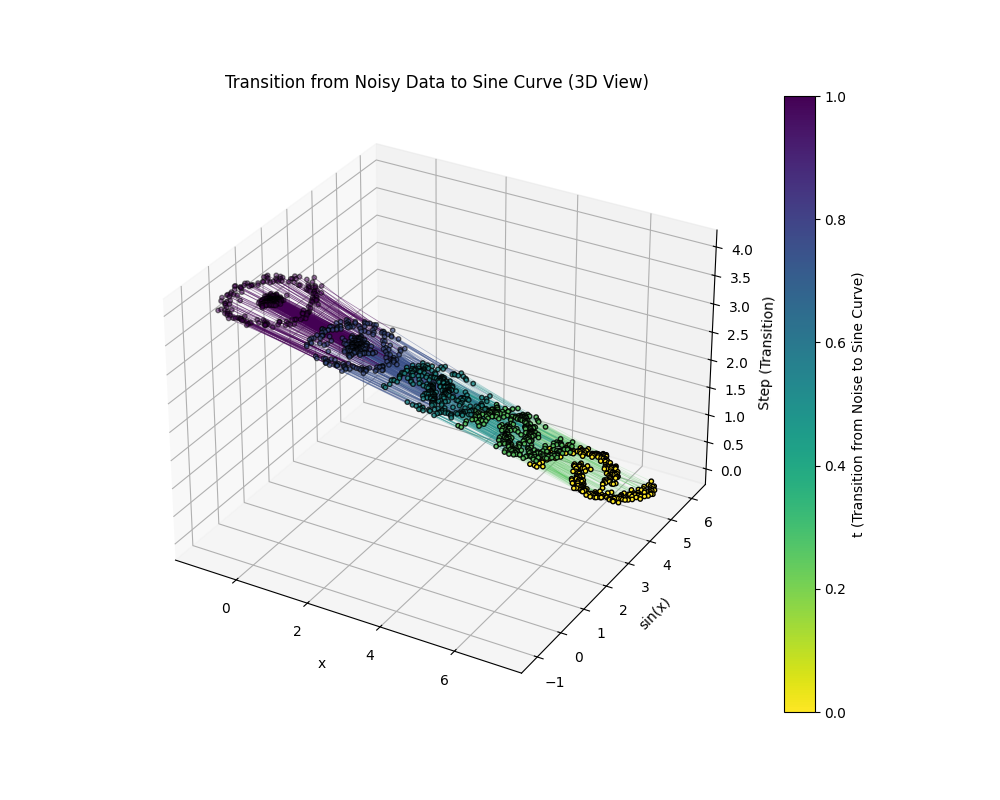

In [8]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons, make_circles

# Enable interactive mode for Jupyter notebooks
%matplotlib widget


# Define the function for 3D trajectory visualization
def visualize_trajectory_sine_curve_3d(z0, z1, n_steps, sigma):
    z0, z1 = match_closest_samples(z0, z1)  # Ensure z0, z1 have similar distributions

    # Initialize the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Color map for trajectory progression
    color_map = plt.cm.viridis_r
    norm = plt.Normalize(vmin=0, vmax=1)

    # Store the previous trajectory for connecting lines
    previous_trajectory = None

    # Iterate over steps and plot each trajectory with color-coded transparency
    for step, t_value in enumerate(torch.linspace(0, 1, n_steps)):
        # Repeat t for batch size of z0 (if z0 has multiple trajectories)
        t = t_value.repeat(z0.shape[0], 1)
        # Calculate the trajectory at this step
        trajectory = generate_trajectory(z0=z0, z1=z1, t=t, sigma=sigma)

        # Scatter plot for each trajectory step
        alpha_scatter = 1 - (0.5 * t_value.item())
        ax.scatter(
            trajectory[:, 0].cpu().numpy(),
            trajectory[:, 1].cpu().numpy(),
            np.full(trajectory.shape[0], step),  # Step as z-coordinate
            color=color_map(norm(t_value.item())),
            alpha=alpha_scatter,
            s=10,  # Size of scatter points
            edgecolors="k",
        )

        # Connect points from previous trajectory to current trajectory
        if previous_trajectory is not None:
            for i in range(trajectory.shape[0]):
                alpha_line = 0.1 + 0.4 * t_value.item()
                ax.plot(
                    [
                        previous_trajectory[i, 0].cpu().numpy(),
                        trajectory[i, 0].cpu().numpy(),
                    ],
                    [
                        previous_trajectory[i, 1].cpu().numpy(),
                        trajectory[i, 1].cpu().numpy(),
                    ],
                    [
                        step - 1,  # z-coordinate for previous step
                        step,  # z-coordinate for current step
                    ],
                    color=color_map(norm(t_value.item())),
                    alpha=alpha_line,
                    linewidth=0.5,
                )

        # Update previous trajectory
        previous_trajectory = trajectory.clone()

    # Add color bar to indicate progression of t
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="t (Transition from Noise to Sine Curve)")

    # Plot labels
    ax.set_title("Transition from Noisy Data to Sine Curve (3D View)")
    ax.set_xlabel("x")
    ax.set_ylabel("sin(x)")
    ax.set_zlabel("Step (Transition)")
    plt.show()


# Define z0 as the sine wave and z1 as noisy data
n_samples = 300
n_steps = 5
sigma = 1e-5

data = make_moons(n_samples=n_samples, noise=0.1)

# Initialize z0 and z1 for trajectory generation
z0 = torch.tensor(data[0], dtype=torch.float32) + 5  # Adjust for visual clarity
z1 = make_circles(n_samples=n_samples, noise=0.1, factor=0.1)[0]

# Call the 3D visualization function
visualize_trajectory_sine_curve_3d(z0, z1, n_steps, sigma)
